# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных
- id— уникальный идентификатор скважины;
- f0, f1, f2— три признака точек (неважно, что они означают, но сами признаки значимы);
- product— объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
df0 = pd.read_csv ('/datasets/geo_data_0.csv')
display (df0)
df0.info ()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [3]:
df1 = pd.read_csv ('/datasets/geo_data_1.csv')
display (df1)
df1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df2 = pd.read_csv ('/datasets/geo_data_2.csv')
display (df2)
df2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Проверяю данные на наличие дубликатов

In [5]:
print ('Количество дубликатов в df0:', df0.duplicated().sum())
print ('Количество дубликатов в df1:', df1.duplicated().sum())
print ('Количество дубликатов в df2:', df2.duplicated().sum())

Количество дубликатов в df0: 0
Количество дубликатов в df1: 0
Количество дубликатов в df2: 0


Открыла таблицы со сведениями по каждому региону. Пропусков и дубликатов в данных не обнаружила. Обнаружила, что у данных разный масштаб, поэтому ниже применю масштабирование.

## Обучение и проверка модели

### Обучение и проверка модели для региона df0

**Разбиваю данные на выборки в соотношении 75-25%**

In [6]:
df0_train, df0_valid = train_test_split(df0, test_size=0.25, random_state=12345) #сначала делю данные 75-25%

features_train0 = df0_train.drop(['product', 'id'], axis=1)
target_train0 = df0_train['product']

features_valid0 = df0_valid.drop(['product', 'id'], axis=1)
target_valid0 = df0_valid['product']

**Масштабирую признаки f0,	f1,	f2**

In [7]:
numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train0[numeric])
features_train0[numeric] = scaler.transform(features_train0[numeric])
features_valid0[numeric] = scaler.transform(features_valid0[numeric])

print(features_train0.shape)
display (features_train0.head(5))

(75000, 3)


,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865
70185,-1.837105,0.010321,-0.147634
82230,-1.299243,0.987558,1.273181


**Запускаю модель линейной регрессии для региона df0**

In [8]:
model = LinearRegression()
model.fit(features_train0, target_train0)
predictions_train0 = model.predict (features_train0)
predictions_valid0 = model.predict(features_valid0)

result0 = mean_squared_error(target_valid0, predictions_valid0)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result0)

RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813


**Считаю среднее абсолютное отколонение MAE**

In [9]:
print("MAE для региона df0 на обучающей выборке: ", mean_absolute_error(target_train0, predictions_train0))
print("MAE для региона df0 на валидационной выборке: ", mean_absolute_error(target_valid0, predictions_valid0))

MAE для региона df0 на обучающей выборке:  31.079961075786297
MAE для региона df0 на валидационной выборке:  30.919600777151313


**Вычисляю значение MAE для медианы целевого признака**

In [10]:
predictions_valid_median0 = pd.Series(target_train0.median(), index=target_valid0.index)
print("Медиана MAE для региона df0", mean_absolute_error(target_valid0, predictions_valid_median0))

Медиана MAE для региона df0 37.67178003955267


Значения MAE на обучающей и валидационных выборках меньше, чем MAE медианы. Значит модель корректно работает.

**Считаю средний запас предсказанного сырья на валидационной выборке**

In [11]:
print (predictions_valid0.mean())

92.59256778438035


### Обучение и проверка модели для региона df1

In [12]:
df1_train, df1_valid = train_test_split(df1, test_size=0.25, random_state=12345) #сначала делю данные 75-25%

features_train1 = df1_train.drop(['product', 'id'], axis=1)
target_train1 = df1_train['product']

features_valid1 = df1_valid.drop(['product', 'id'], axis=1)
target_valid1 = df1_valid['product']

**Масштабирую признаки f0,	f1,	f2**

In [13]:
numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train1[numeric])
features_train1[numeric] = scaler.transform(features_train1[numeric])
features_valid1[numeric] = scaler.transform(features_valid1[numeric])

print(features_train1.shape)
display (features_train1.head(5))

(75000, 3)


,f0,f1,f2
27212,-0.850855,0.624428,0.296943
7866,1.971935,1.832275,0.294333
62041,1.079305,0.170127,-0.296418
70185,-1.512028,-0.887837,-0.880471
82230,-1.804775,-0.718311,-0.293255


**Запускаю модель линейной регрессии для региона df1**

In [14]:
model = LinearRegression()
model.fit(features_train1, target_train1)
predictions_train1 = model.predict (features_train1)
predictions_valid1 = model.predict(features_valid1)

result1 = mean_squared_error(target_valid1, predictions_valid1)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result1)

RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617


**Считаю среднее абсолютное отколонение MAE**

In [15]:
print("MAE для региона df0 на обучающей выборке: ", mean_absolute_error(target_train1, predictions_train1))
print("MAE для региона df1 на валидационной выборке: ", mean_absolute_error(target_valid1, predictions_valid1))

MAE для региона df0 на обучающей выборке:  0.7168438837861948
MAE для региона df1 на валидационной выборке:  0.7187662442124758


**Вычисляю значение MAE для медианы целевого признака**

In [16]:
predictions_valid_median1 = pd.Series(target_train1.median(), index=target_valid1.index)
print("Медиана MAE для региона df1", mean_absolute_error(target_valid1, predictions_valid_median1))

Медиана MAE для региона df1 40.26547941945416


**Считаю средний запас предсказанного сырья на валидационной выборке**

In [17]:
print (predictions_valid1.mean())

68.728546895446


### Обучение и проверка модели для региона df2

In [18]:
df2_train, df2_valid = train_test_split(df2, test_size=0.25, random_state=12345) #сначала делю данные 75-25%

features_train2 = df2_train.drop(['product', 'id'], axis=1)
target_train2 = df2_train['product']

features_valid2 = df2_valid.drop(['product', 'id'], axis=1)
target_valid2 = df2_valid['product']

**Масштабирую признаки f0,	f1,	f2**

In [19]:
numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train2[numeric])
features_train2[numeric] = scaler.transform(features_train2[numeric])
features_valid2[numeric] = scaler.transform(features_valid2[numeric])

print(features_train2.shape)
display (features_train2.head(5))

(75000, 3)


,f0,f1,f2
27212,-0.526160,0.776329,-0.400793
7866,-0.889625,-0.404070,-1.222936
62041,-1.133984,0.208576,0.296765
70185,1.227045,1.570166,-0.764556
82230,-0.194289,0.878312,0.840821


**Запускаю модель линейной регрессии для региона df2**

In [20]:
model = LinearRegression()
model.fit(features_train2, target_train2)
predictions_train2 = model.predict (features_train2)
predictions_valid2 = model.predict(features_valid2)

result2 = mean_squared_error(target_valid2, predictions_valid2)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result2)

RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434


**Считаю среднее абсолютное отколонение MAE**

In [21]:
print("MAE для региона df2 на обучающей выборке: ", mean_absolute_error(target_train2, predictions_train2))
print("MAE для региона df2 на валидационной выборке: ", mean_absolute_error(target_valid2, predictions_valid2))

MAE для региона df2 на обучающей выборке:  32.83941121639209
MAE для региона df2 на валидационной выборке:  32.792652105481814


**Вычисляю значение MAE для медианы целевого признака**

In [22]:
predictions_valid_median2 = pd.Series(target_train2.median(), index=target_valid2.index)
print("Медиана MAE для региона df2", mean_absolute_error(target_valid2, predictions_valid_median2))

Медиана MAE для региона df2 37.92103997436729


**Считаю средний запас предсказанного сырья на валидационной выборке**

In [23]:
print (predictions_valid2.mean())

94.96504596800489


### Графики распределения предсказанного количества нефти (predictions_valid) в разных регионах

<AxesSubplot:>

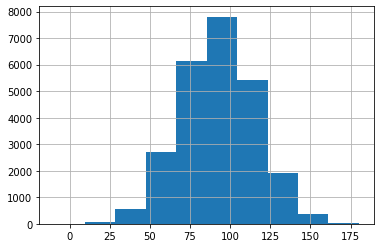

In [24]:
pd.Series(predictions_valid0).hist ()

<AxesSubplot:>

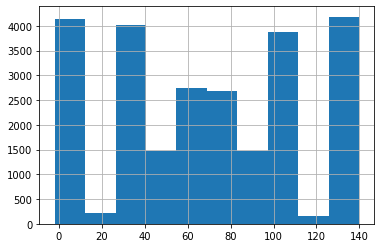

In [25]:
pd.Series(predictions_valid1).hist ()

<AxesSubplot:>

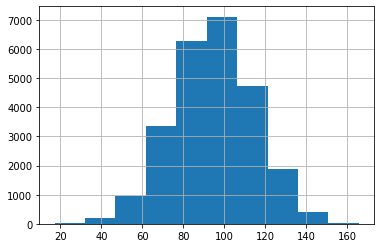

In [26]:
pd.Series(predictions_valid2).hist ()

Если в df0 и df2 у нас идет нормальное распределение количества нефти по скважинам, то в df1 график получился какой-то странный.

## Подготовка к расчёту прибыли

### Рассчет объема сырья, достаточного для безубыточной работы скважины

In [27]:
#цена разработки 1 скважины (10 млрд. руб (цена разработки всех скважин в регионе) делим \
#на 200 скважин (200 лучших точек, которые будут разрабатывать))

development_1_well = 10**10 / 200
print ('Цена разработки 1 скважины', development_1_well, 'рублей')

#считаю, сколько должно быть нефти в скважине, чтобы она была безубыточной (цену разработки 1 скваж. делим на ст-ть 1 ед.сырья)
break_even_oil = development_1_well / 450000
print ('Количество нефти для безубыточной работы 1 скважины', break_even_oil, 'тыс. баррелей')

#стоимость должно быть нефти в регионе, чтобы его разработка была безубыточной
development_all_wells = 10**10 / 450000
print ('Количество нефти в регионе для его безубыточной работы', development_all_wells, 'тыс. баррелей')

Цена разработки 1 скважины 50000000.0 рублей
Количество нефти для безубыточной работы 1 скважины 111.11111111111111 тыс. баррелей
Количество нефти в регионе для его безубыточной работы 22222.222222222223 тыс. баррелей


Для безубыточной работы 1 скважины требуется 111,1 тыс. баррелей нефти.\
Среднее количество нефти в скважинах региона 0 составляет 92,6 тыс. баррелей нефти.\
Среднее количество нефти в скважинах региона 1 составляет 68,7 тыс. баррелей нефти.\
Среднее количество нефти в скважинах региона 2 составляет 94,96 тыс. баррелей нефти.

### Отбор 200 лучших скважин в каждом регионе и подсчет количества нефти

In [28]:
predictions_valid0_200 = pd.Series(predictions_valid0).sort_values(ascending=False)
predictions_valid0_200_sum = predictions_valid0_200[0:200].sum()
print ('Количество нефти в двухсот лучших скважинах региона 0:', predictions_valid0_200_sum)

Количество нефти в двухсот лучших скважинах региона 0: 31102.330838811402


In [29]:
predictions_valid1_200 = pd.Series(predictions_valid1).sort_values(ascending=False)
predictions_valid1_200_sum = predictions_valid1_200[0:200].sum()
print ('Количество нефти в двухсот лучших скважинах региона 1:', predictions_valid1_200_sum)

Количество нефти в двухсот лучших скважинах региона 1: 27746.02678216343


In [30]:
predictions_valid2_200 = pd.Series(predictions_valid2).sort_values(ascending=False)
predictions_valid2_200_sum = predictions_valid2_200[0:200].sum()
print ('Количество нефти в двухсот лучших скважинах региона 2:', predictions_valid2_200_sum)

Количество нефти в двухсот лучших скважинах региона 2: 29603.89865831835


## Расчёт прибыли и рисков 

### Сброс индексов на валидационной выборке

In [31]:
target_valid0 = pd.concat([pd.Series(target_valid0)], ignore_index=True)
target_valid1 = pd.concat([pd.Series(target_valid1)], ignore_index=True)
target_valid2 = pd.concat([pd.Series(target_valid2)], ignore_index=True)

state = np.random.RandomState(12345)

print(target_valid0)
print(predictions_valid0)
target_subsample = target_valid0.sample(frac=0.02, replace=True, random_state=state)
print(target_subsample)
print(target_subsample.index[0])
predictions_valid0[target_subsample.index][0]

### Функция для подсчета прибыли

In [32]:
def profit (target, predictions, count):
    predictions_sorted = pd.Series(predictions).sort_values(ascending=False)
    selected_200 = predictions_sorted[:count]
    selected_200_target = target.iloc[selected_200.index]
    selected_sum = selected_200_target.sum()
    profit = selected_sum*450000 - 10**10
    return profit

### Считаю предполагаемую прибыль для каждого региона

In [33]:
print ('Прибыль региона 0 составляет:', profit (target_valid0, predictions_valid0, 200)/10**9, 'млрд. рублей')

Прибыль региона 0 составляет: 3.3208260431398506 млрд. рублей


In [34]:
print ('Прибыль региона 1 составляет:', profit (target_valid1, predictions_valid1, 200)/10**9, 'млрд. рублей')

Прибыль региона 1 составляет: 2.4150866966815108 млрд. рублей


In [35]:
print ('Прибыль региона 2 составляет:', profit (target_valid2, predictions_valid2, 200)/10**9, 'млрд. рублей')

Прибыль региона 2 составляет: 2.7103499635998327 млрд. рублей


### Применяю технику Bootstrap, чтобы найти распределение прибыли

In [36]:
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    target_subsample = target_valid0.sample(frac=0.02, replace=True, random_state=state)
    probs_subsample = predictions_valid0[target_subsample.index]
    value = profit (target_subsample, probs_subsample, 200)
    values.append(value)

values_series = pd.Series(values)
lower = values_series.quantile(0.025)
upper = values_series.quantile(0.975)
values_mean = values_series.mean()

print ('Распределение прибыли в регионе 0:')
print("95% доверительный интервал:", lower/10**9, ' - ', upper/10**9)
print ('Средняя прибыль региона 0:', values_mean/10**9, 'млрд. рублей')

Распределение прибыли в регионе 0:
95% доверительный интервал: -0.11121554589049526  -  0.9097669415534225
Средняя прибыль региона 0: 0.3961649848023711 млрд. рублей


In [37]:
values_loss = 0
values_profit = 0
for i in values:
    if i < 0:
        values_loss = values_loss + 1
    else:
        values_profit = values_profit + 1
print ('Вероятность убытка в регионе 0 равна', values_loss*100/1000, '%')

Вероятность убытка в регионе 0 равна 6.9 %


In [38]:
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    target_subsample = target_valid1.sample(frac=0.02, replace=True, random_state=state)
    probs_subsample = predictions_valid1[target_subsample.index]
    value = profit (target_subsample, probs_subsample, 200)
    values.append(value)

values_series = pd.Series(values)
lower = values_series.quantile(0.025)
upper = values_series.quantile(0.975)
values_mean = values_series.mean()

print ('Распределение прибыли в регионе 1:')
print("95% доверительный интервал:", lower/10**9, ' - ', upper/10**9)
print ('Средняя прибыль региона 1:', values_mean/10**9, 'млрд. рублей')

Распределение прибыли в регионе 1:
95% доверительный интервал: 0.03382050939898363  -  0.852289453866036
Средняя прибыль региона 1: 0.4560451057866608 млрд. рублей


In [39]:
values_loss = 0
values_profit = 0
for i in values:
    if i < 0:
        values_loss = values_loss + 1
    else:
        values_profit = values_profit + 1
print ('Вероятность убытка в регионе 1 равна', values_loss*100/1000, '%')

Вероятность убытка в регионе 1 равна 1.5 %


In [40]:
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    target_subsample = target_valid2.sample(frac=0.02, replace=True, random_state=state)
    probs_subsample = predictions_valid2[target_subsample.index]
    value = profit (target_subsample, probs_subsample, 200)
    values.append(value)

values_series = pd.Series(values)
lower = values_series.quantile(0.025)
upper = values_series.quantile(0.975)
values_mean = values_series.mean()

print ('Распределение прибыли в регионе 2:')
print("95% доверительный интервал:", lower/10**9, ' - ', upper/10**9)
print ('Средняя прибыль региона 2:', values_mean/10**9, 'млрд. рублей')

Распределение прибыли в регионе 2:
95% доверительный интервал: -0.16335041339560105  -  0.9503595749237995
Средняя прибыль региона 2: 0.4044038665683568 млрд. рублей


In [41]:
values_loss = 0
values_profit = 0
for i in values:
    if i < 0:
        values_loss = values_loss + 1
    else:
        values_profit = values_profit + 1
print ('Вероятность убытка в регионе 2 равна', values_loss*100/1000, '%')

Вероятность убытка в регионе 2 равна 7.6 %


## Вывод

Добывающая компания «ГлавРосГосНефть» поставила задачу о том, где бурить новую скважину.\
Была предоставлена информация о трех предполагаемых регионах для бурения скважин.\
\
Я вычислила следующие основные параметры:\
Стоимость разработки 1 скважины составляет 5 млн. рублей\
Для безубыточной работы 1 скважины требуется 111,1 тыс. баррелей нефти.\
Среднее количество нефти в скважинах региона 0 составляет 92,6 тыс. баррелей нефти.\
Среднее количество нефти в скважинах региона 1 составляет 68,7 тыс. баррелей нефти.\
Среднее количество нефти в скважинах региона 2 составляет 94,96 тыс. баррелей нефти.\
\
Применила технику Bootstrap и нашла 95% доверительный интервал в каждом регионе.\
Наибольшую среднюю прибыль и наименьшую вероятность убытка показал регион 1 (вероятность убытков 1,5%).\
В то время, как регион 0 показал вероятность убытков 6,9%, а регион 2 - 7,6%.\
\
Распределение прибыли в регионе 1:\
95% доверительный интервал: 0.03382050939898363  -  0.852289453866036\
Средняя прибыль региона 1: 0.4560451057866608 млрд. рублей\
Поэтому, с точки зрения размера средней прибыли и наименьшей вероятности убытков, стоит выбрать регион 1 для разработки.